# Kaggle Competition : Home Credit Default Risk

> Predict how capable each applicant is of repaying a loan.

References:<br>
[Data Sources](https://www.kaggle.com/c/home-credit-default-risk/data) <br>
[Start Here: A Gentle Introduction](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction)<br>

task:

> 1. Check dataset

> 2. EDA (Exploratory Data Analysis)

            a. Anomalies (Outlinear)
            b. Correlations

> 3. Data Processing

            a. missing value
            b. transform categorical data

> 4. Fit different models and make prediction

            a. Logistic Regression classifier
            b. Random Forest classifier
            c. XGBoost classifier

> 5. Predict the data for kaggle submission

#### kaggle submission result 

![submission result](result/HCDR.jpg)

#### Feature importance by Randon forest Regressor

![submission result](result/HCDR_feature_importance.jpg)

# 1. Check dataset

In [2]:
import pandas as pd
import numpy as np

In [3]:
df_train = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')
df_test = pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv')

In [4]:
df_train.shape

(307511, 122)

In [5]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_test.shape

(48744, 121)

#### inbalanced data

91% of data is 0 (loans that were repaid on time), 8% of data is 1 (loans that were not repaid on time). 

In [7]:
df_train['TARGET'].value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

# 2. EDA (Exploratory Data Analysis)

task:

> a. Anomalies (Outlinear)

> b. Correlations

#### a. Anomalies (Outlinear)

In [8]:
pd.set_option('display.max_rows', 15)

The column 'DAYS_EMPLOYED' shows something wrong. 

In [9]:
df_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [10]:
import matplotlib.pyplot as plt

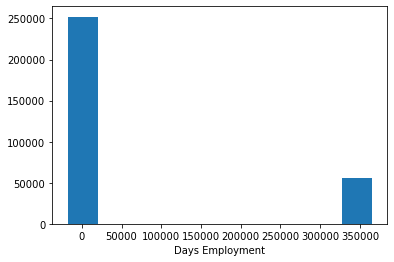

In [11]:
plt.hist(df_train['DAYS_EMPLOYED'])
plt.xlabel('Days Employment')
plt.show()

We find anomalies when df_train['DAYS_EMPLOYED'] == 365243, now check whether this has influence on target. 

In [12]:
anom = df_train[df_train['DAYS_EMPLOYED'] == 365243]
non_anom = df_train[df_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans.' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans.' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment.' % len(anom))

The non-anomalies default on 8.66% of loans.
The anomalies default on 5.40% of loans.
There are 55374 anomalous days of employment.


Anomalies shows different in default.  <br>
Let's fill in the anomalous values with 'np.nan', and create a new boolean column indicating whether or not the value was anomalous.

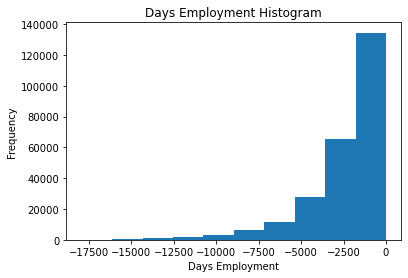

In [13]:
# Create an anomalous flag column
df_train['DAYS_EMPLOYED_ANOM'] = df_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
df_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

df_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Do the same transformation in testing data

In [14]:
df_test['DAYS_EMPLOYED_ANOM'] = df_test["DAYS_EMPLOYED"] == 365243
df_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (df_test["DAYS_EMPLOYED_ANOM"].sum(), len(df_test)))

There are 9274 anomalies in the test data out of 48744 entries


#### b. Correlations

In [15]:
# Find correlations between taget and other variables.
correlations = df_train.corr()['TARGET'].sort_values()

In [16]:
correlations

EXT_SOURCE_3                  -0.178919
EXT_SOURCE_2                  -0.160472
EXT_SOURCE_1                  -0.155317
DAYS_EMPLOYED_ANOM            -0.045987
FLOORSMAX_AVG                 -0.044003
                                 ...   
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, Length: 107, dtype: float64

The range of correlation is between 0.07 ~ -0.17. This shows week correlation between variables and target.

* Let's check Effect of **'DAYS_BIRTH'** on Repayment by kernel density estimation (KDE) Plot.

In [17]:
import seaborn as sns

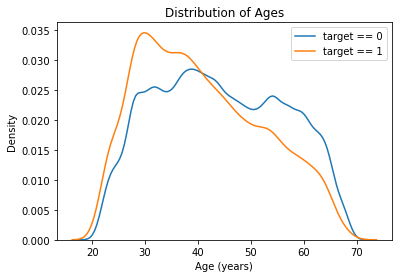

In [18]:
plt.figure(figsize = (6, 4))

# KDE plot of loans that were repaid on time
sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

Although the correlation between 'DAYS_BIRTH' and 'Target' is only 0.07, the plot showss that the curve of target == 1 skews towards the younger side of age. 

This means that even if correlation is low, it may still has effect on target. 

* Let's check Effect of **'Exterior Sources'** on Repayment by kernel density estimation (KDE).

The 3 'Exterior Sources' variables shows negative correlations with the target. <br>
The documentation says they represent a "normalized score from external data source". <br>

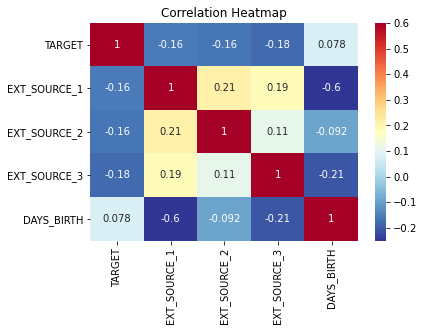

In [19]:
plt.figure(figsize = (6, 4))

cor_ext =  df_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].corr()

# Heatmap of correlations
sns.heatmap(cor_ext, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

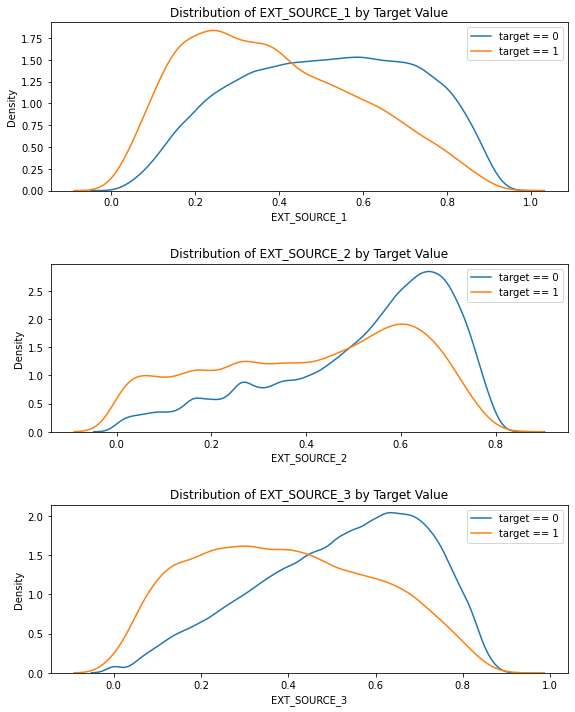

In [20]:
plt.figure(figsize = (8, 10))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

By kernel density estimation (KDE), we can find EXT_SOURCE_1 and EXT_SOURCE_3 show different distributions when target is different. 

# 3. Data Processing

task:

> a. missing value

> b. transform categorical data

#### a. missing value

In [21]:
col_missing = list(df_train.columns[df_train.isnull().any()])

In [22]:
print('There are {} columns that have missing values.'.format(len(col_missing)))

There are 68 columns that have missing values.


In [23]:
# show missing value as percentage of total data

df_train[col_missing].isnull().sum(axis = 0)/df_train.shape[0]

AMT_ANNUITY                   0.000039
AMT_GOODS_PRICE               0.000904
NAME_TYPE_SUITE               0.004201
DAYS_EMPLOYED                 0.180072
OWN_CAR_AGE                   0.659908
                                ...   
AMT_REQ_CREDIT_BUREAU_DAY     0.135016
AMT_REQ_CREDIT_BUREAU_WEEK    0.135016
AMT_REQ_CREDIT_BUREAU_MON     0.135016
AMT_REQ_CREDIT_BUREAU_QRT     0.135016
AMT_REQ_CREDIT_BUREAU_YEAR    0.135016
Length: 68, dtype: float64

* Now use sklearn self-defined  **Imputer** to fill in missing value of Categorical data and Numerical data. 

Function from: [Impute categorical missing values in scikit-learn](https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn)

In [24]:
from sklearn.base import TransformerMixin

In [25]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [26]:
imp = DataFrameImputer()
imp.fit(df_train)

df_train = imp.transform(df_train)
df_test = imp.transform(df_test)

In [27]:
# No missing value after imputataion. 

df_train[col_missing].isnull().sum(axis = 0)/df_train.shape[0]

AMT_ANNUITY                   0.0
AMT_GOODS_PRICE               0.0
NAME_TYPE_SUITE               0.0
DAYS_EMPLOYED                 0.0
OWN_CAR_AGE                   0.0
                             ... 
AMT_REQ_CREDIT_BUREAU_DAY     0.0
AMT_REQ_CREDIT_BUREAU_WEEK    0.0
AMT_REQ_CREDIT_BUREAU_MON     0.0
AMT_REQ_CREDIT_BUREAU_QRT     0.0
AMT_REQ_CREDIT_BUREAU_YEAR    0.0
Length: 68, dtype: float64

#### b. transform categorical data

In [28]:
# Number of each type of column
df_train.dtypes.value_counts()

float64    66
int64      40
object     16
bool        1
dtype: int64

In [29]:
# Number of unique classes in each object column
df_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE      2
CODE_GENDER             3
FLAG_OWN_CAR            2
FLAG_OWN_REALTY         2
NAME_TYPE_SUITE         7
                       ..
ORGANIZATION_TYPE      58
FONDKAPREMONT_MODE      4
HOUSETYPE_MODE          3
WALLSMATERIAL_MODE      7
EMERGENCYSTATE_MODE     2
Length: 16, dtype: int64

* Label encoding  →  columns with 2 unique categories.  <br>
* One-hot encoding  →  columns variable with more than 2 unique categories.

In [30]:
#  columns with 2 unique categories
columns_ob_two = ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE', 'DAYS_EMPLOYED_ANOM']

Label encoding of 2 unique categorical variables

In [31]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in columns_ob_two:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

One-hot encoding of more than two unique categorical variable

In [32]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

To remove the columns in the training data that are not in the testing data, we need to align the dataframes. 

In [33]:
train_labels = df_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)

# Add the target back in
df_train['TARGET'] = train_labels

print('Training Features shape: ', df_train.shape)
print('Testing Features shape: ', df_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


# 4. Fit different Models

Task:

> a. Logistic Regression classifier

> b. Random Forest classifier

> c. XGBoost classifier

#### a. Logistic Regression

In [34]:
from sklearn.preprocessing import MinMaxScaler

In [35]:
# define training and testing data
y_train = df_train['TARGET']

X_train = df_train.copy().drop(columns = ['TARGET'])
X_test = df_test.copy()

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Training data shape: ', X_train_scaled.shape)
print('Testing data shape: ', X_test_scaled.shape)

Training data shape:  (307511, 239)
Testing data shape:  (48744, 239)


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [36]:
params_log  = { 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'penalty': ['l1', 'l2']}

log = LogisticRegression()

In [37]:
gs_log = GridSearchCV(log, params_log, cv=5, n_jobs=-1, verbose=1)

# fitting the model for grid search 
gs_log.fit(X_train_scaled , y_train)

# summarize
print('Mean Accuracy: %.3f' % gs_log.best_score_)
print('Config: %s' % gs_log.best_params_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  5.1min finished


Mean Accuracy: 0.919
Config: {'C': 0.001, 'penalty': 'l2'}


#### b. Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [40]:
rfc = RandomForestClassifier(min_samples_split = 10, min_samples_leaf = 4, max_features = 'sqrt')

params_rfc = {'max_depth': [10, 25, 50, 75, 100],
              'n_estimators': [50, 100, 200]}


In [41]:
gs_rfc = GridSearchCV(rfc, params_rfc, cv=4, n_jobs=-1, verbose=1)

In [42]:
gs_rfc.fit(X_train_scaled , y_train)

# summarize
print('Mean Accuracy: %.3f' % gs_rfc.best_score_)
print('Config: %s' % gs_rfc.best_params_)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 37.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 56.9min finished


Mean Accuracy: 0.919
Config: {'max_depth': 50, 'n_estimators': 50}


In [37]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    fi_df = fi_df.iloc[0:30, ]

    #Define size of bar plot
    plt.figure(figsize=(10,8))

    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [46]:
rfc_best = RandomForestClassifier(max_depth = 50, max_features = 'sqrt', n_estimators = 50, min_samples_split = 10, min_samples_leaf = 4 )
rfc_best.fit(X_train_scaled , y_train)

RandomForestClassifier(max_depth=50, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=50)

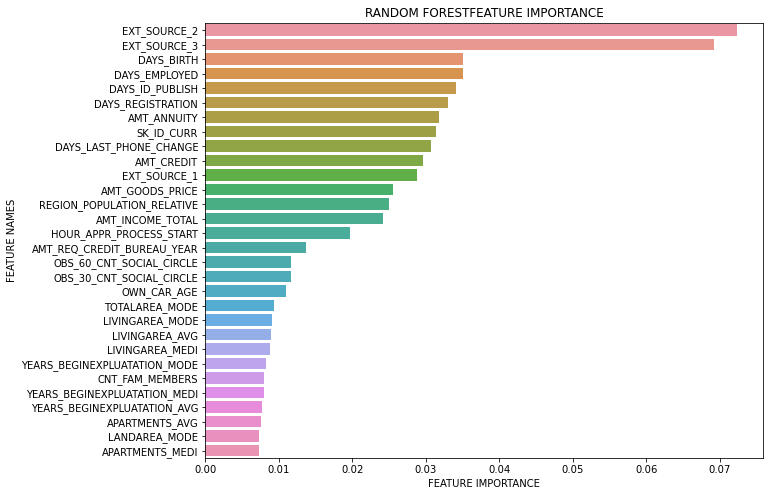

In [47]:
plot_feature_importance(rfc_best.feature_importances_, df_train.columns[0:-1], 'RANDOM FOREST')

#### c. XGBoost classifier

[API document](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

In [38]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [47]:
# try XGBoost with GridsearchCV
params_xgb = {'n_estimators': [100, 250, 500],
              'learning_rate': [0.05, 0.1, 0.5, 1.0]}

xgb = XGBClassifier()

In [48]:
gs_xgb = GridSearchCV(xgb, params_xgb, verbose=1, cv=4, n_jobs=-1)

In [49]:
gs_xgb.fit(X_train_scaled, y_train)

# summarize
print('Mean Accuracy: %.3f' % gs_xgb.best_score_)
print('Config: %s' % gs_xgb.best_params_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 266.7min finished


Mean Accuracy: 0.919
Config: {'learning_rate': 0.05, 'n_estimators': 100}


In [49]:
xgb_best = XGBClassifier(learning_rate = 0.05,n_estimators = 100 )
xgb_best.fit(X_train_scaled , y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# 5. predict the data for submission

#### a. Logistic Regression

In [ ]:
# Make predictions
# Make sure to select the second column only
result_log = gs_log.predict_proba(X_test_scaled)[:, 1]

In [ ]:
submission_log = pd.DataFrame({'SK_ID_CURR': df_test['SK_ID_CURR'], 'TARGET': result_log})

In [ ]:
# submission_log.to_csv('result/HCDR_submission_log.csv', index = False)

#### b. Random Forest

In [ ]:
result_rfc = rfc_best.predict_proba(X_test_scaled)[:, 1]

In [ ]:
submission_rfc = pd.DataFrame({'SK_ID_CURR': df_test['SK_ID_CURR'], 'TARGET': result_rfc})

In [ ]:
# submission_rfc.to_csv('HCDR_submission_rfc.csv', index = False)

#### c. XGBoost classifier

In [50]:
result_xgb = xgb_best.predict_proba(X_test_scaled)[:, 1]

In [51]:
submission_xgb = pd.DataFrame({'SK_ID_CURR': df_test['SK_ID_CURR'], 'TARGET': result_xgb})

In [52]:
submission_xgb.to_csv('HCDR_submission_xgb.csv', index = False)